In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Imports
import torch
import torch.nn as nn
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [4]:
from vae import VAE
from vae import GroupSoftmax
from trainer import Trainer

In [5]:
# Device config 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [6]:
# load data 
data = pd.read_csv('/mnt/a/csv_hde/one_hot_data.csv')
data_tensor = torch.tensor(data.values, dtype=torch.float32)
# load model 
cols = list(data.columns)
cols = [col.split(":")[0] for col in cols]

onehot_counts = {col: sum(data.columns.str.startswith(f"{col}:")) for col in cols}
group_sizes = list(onehot_counts.values())

model = VAE(375, 600, 6, 250, group_sizes)
model.load_state_dict(torch.load('/mnt/a/models/best_model.pth'))
model.eval()

VAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): MLPBlock(
        (layers): Sequential(
          (0): Linear(in_features=375, out_features=600, bias=True)
          (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ResidualBlock(
        (mlp1): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_features=600, out_features=600, bias=True)
            (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (mlp2): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_features=600, out_features=600, bias=True)
            (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (2): ResidualBlock(
        (mlp1): MLPBlock(
          (layers): Sequential(
            (0): Linear(in_fea

In [7]:
# sample from the model 
n_samples = len(data)

# sample from the model
predicted = torch.mean(model.pretrain_sample(n_samples), dim=0).detach().cpu().numpy()

# apply the group softmax to the data
group_softmax = GroupSoftmax(group_sizes)
ground_truth = torch.mean(group_softmax(data_tensor), dim=0).detach().cpu().numpy()

print(f'ground_truth: {ground_truth.shape}')
print(f'predicted: {predicted.shape}')


ground_truth: (375,)
predicted: (375,)


In [8]:
# prepare dicts and namings for plotting
labels = list(data.columns)
labels = [label.split(":") for label in labels]
feature_label_dict = {}
for key, label in labels:
    if key in feature_label_dict:
        feature_label_dict[key].append(label) 
    else:
        feature_label_dict[key] = [label]

indices = {}

for key, labels in labels:
    if key in indices:
        indices[key].append( data.columns.get_loc(f"{key}:{labels}"))
    else:
        indices[key] = [data.columns.get_loc(f"{key}:{labels}")]

print(feature_label_dict)
print(indices)
#data_dict = {data.columns}

{'TEN': ['owned or mortgaged', 'rented'], 'HHL': ['english', 'spanish', 'other indo-european'], 'VEH': ['no vehicles', '1 vehicle', '2 vehicles', '3 vehicles', '4 or more vehicles'], 'HINCP': ['under 5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-35k', '35k-50k', '50k-75k', '75k-100k', '100k-150k', '150k+'], 'R65': ['no', 'yes'], 'R18': ['no', 'yes'], 'SEX_1': ['male', 'female'], 'SEX_2': ['male', 'female'], 'SEX_3': ['male', 'female'], 'SEX_4': ['male', 'female'], 'SEX_5': ['male', 'female'], 'SEX_6': ['male', 'female'], 'SEX_7': ['male', 'female'], 'SEX_8': ['male', 'female'], 'SEX_9': ['male', 'female'], 'SEX_10': ['male', 'female'], 'SEX_11': ['male', 'female'], 'SEX_12': ['male', 'female'], 'SEX_13': ['male', 'female'], 'SEX_14': ['male', 'female'], 'AGEP_1': ['under 5', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+'], 'AGEP_2': ['under 5', '5-9', '10-14', '15-19', '20-24', '

In [9]:

ten_dict = {key: [] for key in feature_label_dict['TEN']}
hhl_dict = {key: [] for key in feature_label_dict['HHL']}
veh_dict = {key: [] for key in feature_label_dict['VEH']}
hincp_dict = {key: [] for key in feature_label_dict['HINCP']}
sex_dict = {key: [] for key in feature_label_dict['SEX_1']}
education_dict = {key: [] for key in feature_label_dict['SCHL_1']}
age_dict = {key: [] for key in feature_label_dict['AGEP_1']}
r18_dict = {key: [] for key in feature_label_dict['R18']}
r65_dict = {key: [] for key in feature_label_dict['R65']}

# create dicts for the groups and their indices 
for key, labels in feature_label_dict.items():
    if 'SEX' in key:
        for idx, label in enumerate(labels):
            sex_dict[label].append(indices[key][idx])
    elif 'SCHL' in key:
        for idx, label in enumerate(labels):
            education_dict[label].append(indices[key][idx])
    elif 'AGEP' in key:
        for idx, label in enumerate(labels):
            age_dict[label].append(indices[key][idx])
    elif 'TEN' in key:
        for idx, label in enumerate(labels):
            ten_dict[label].append(indices[key][idx])
    elif 'HHL' in key:
        for idx, label in enumerate(labels):
            hhl_dict[label].append(indices[key][idx])
    elif 'VEH' in key:
        for idx, label in enumerate(labels):
            veh_dict[label].append(indices[key][idx])
    elif 'HINCP' in key:
        for idx, label in enumerate(labels):
            hincp_dict[label].append(indices[key][idx])
    elif 'R18' in key:
        for idx, label in enumerate(labels):
            r18_dict[label].append(indices[key][idx])
    elif 'R65' in key:
        for idx, label in enumerate(labels):
            r65_dict[label].append(indices[key][idx])




In [10]:
# rewrite the cell above into a function
def plot_group(group_name, ground_truth, predicted, feature_label_dict, dict_name):
    fig, ax = plt.subplots()

    x = np.arange(len(feature_label_dict[group_name]))
    width = 0.35
    keys = feature_label_dict[group_name]

    ax.bar(x - width/2, np.array([ground_truth[dict_name[k]] for k in keys]).flatten(), width, label='Ground Truth')
    ax.bar(x + width/2, np.array([predicted[dict_name[k]] for k in keys]).flatten(), width, label='Predicted')
    ax.set_ylabel('Probability')
    ax.set_title(group_name)
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    plt.xticks(rotation=90)
    plt.show()

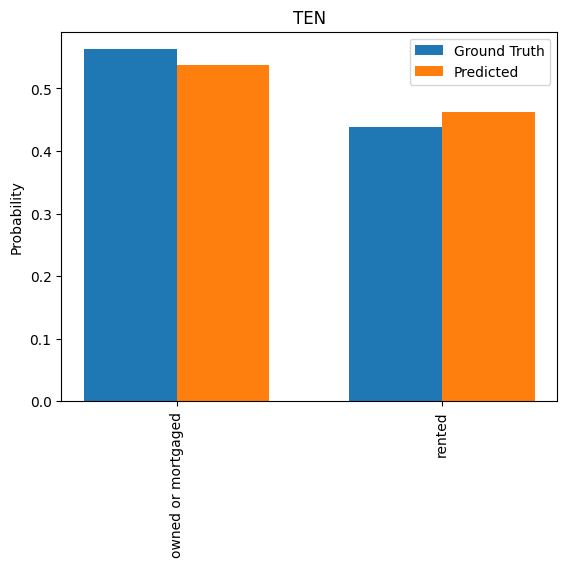

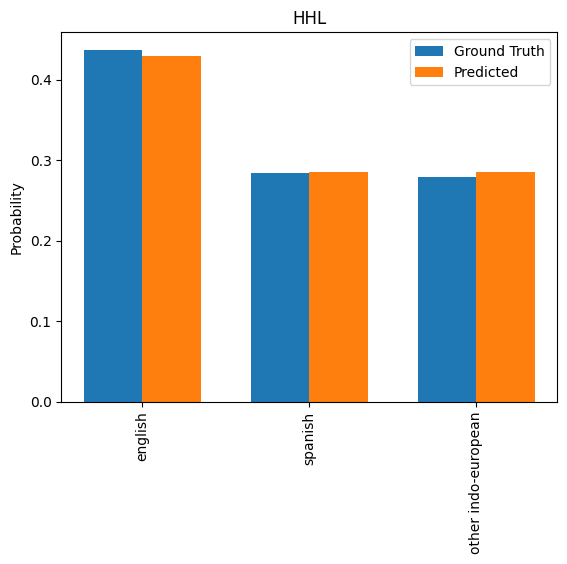

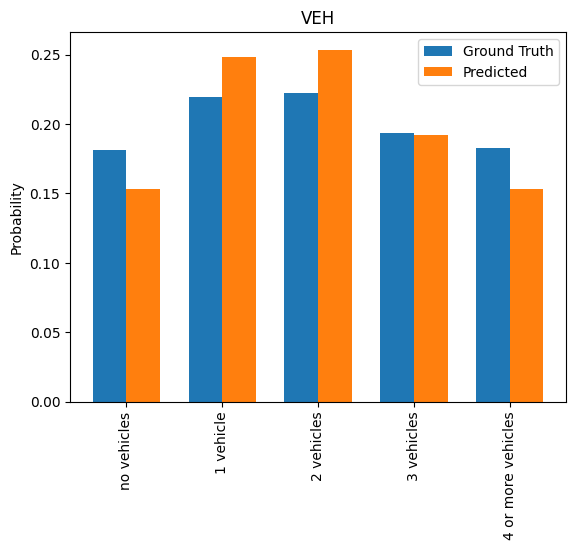

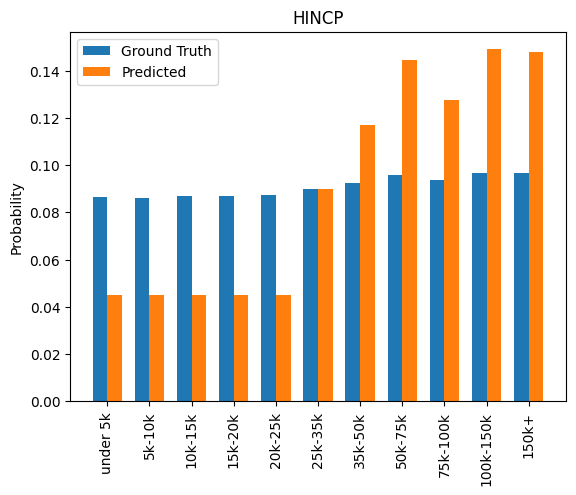

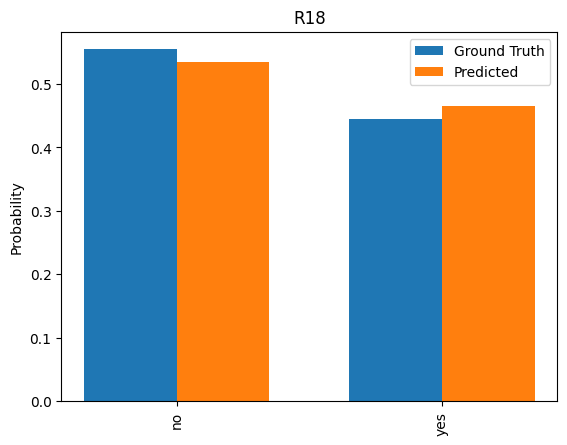

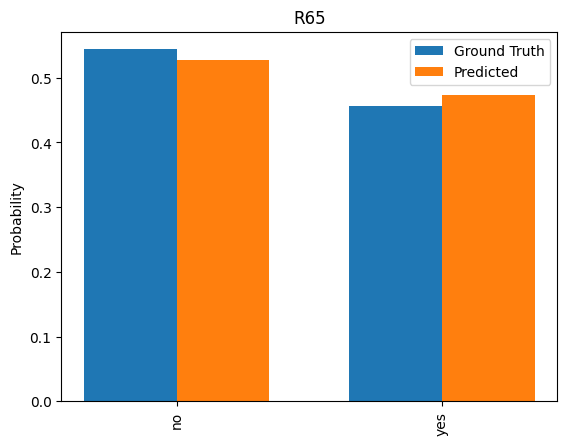

In [11]:
plot_group('TEN', ground_truth, predicted, feature_label_dict, ten_dict)
plot_group('HHL', ground_truth, predicted, feature_label_dict, hhl_dict)
plot_group('VEH', ground_truth, predicted, feature_label_dict, veh_dict)
plot_group('HINCP', ground_truth, predicted, feature_label_dict, hincp_dict)
plot_group('R18', ground_truth, predicted, feature_label_dict, r18_dict)
plot_group('R65', ground_truth, predicted, feature_label_dict, r65_dict)

In [12]:
# average the values for sex, education and agep
def average_group(group_name, ground_truth, predicted, feature_label_dict, dict_name):
    keys = feature_label_dict[group_name]
    ground_truth = np.array([ground_truth[dict_name[k]] for k in keys])
    predicted = np.array([predicted[dict_name[k]] for k in keys])
    return np.mean(ground_truth, axis=1), np.mean(predicted, axis=1), keys


In [13]:
sex_gt_mean, sex_pred_mean, sex_keys = average_group('SEX_1', ground_truth, predicted, feature_label_dict, sex_dict)
ed_gt_mean, ed_pred_mean, ed_keys = average_group('SCHL_1', ground_truth, predicted, feature_label_dict, education_dict)
age_gt_mean, age_pred_mean, agep_keys = average_group('AGEP_1', ground_truth, predicted, feature_label_dict, age_dict)

In [14]:
def plot_group_mean(group_name, ground_truth, predicted, keys):
    fig, ax = plt.subplots()

    x = np.arange(len(keys))
    width = 0.35

    ax.bar(x - width/2, ground_truth, width, label='Ground Truth')
    ax.bar(x + width/2, predicted, width, label='Predicted')
    ax.set_ylabel('Probability')
    ax.set_title(group_name)
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    plt.xticks(rotation=90)
    plt.show()

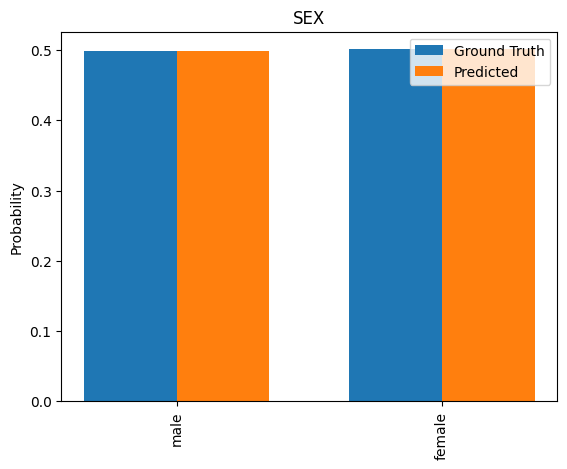

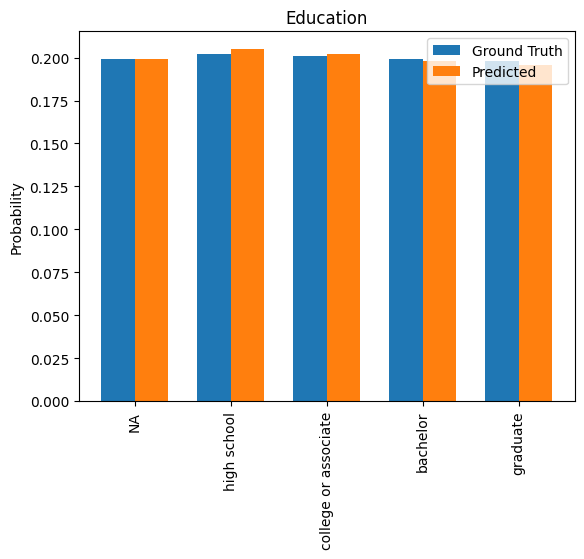

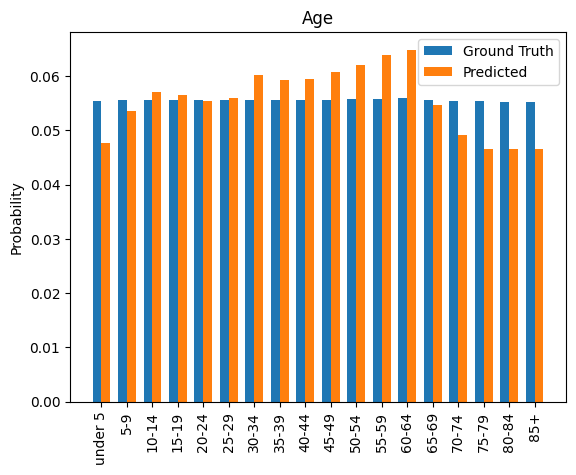

In [15]:
plot_group_mean('SEX', sex_gt_mean, sex_pred_mean, sex_keys)
plot_group_mean('Education', ed_gt_mean, ed_pred_mean, ed_keys)
plot_group_mean('Age', age_gt_mean, age_pred_mean, agep_keys)
